In [1]:
# Cell 1 — Mount Drive & install dependencies
from google.colab import drive
drive.mount('/content/drive')

# Install Grad-CAM & OpenCV
!pip install grad-cam opencv-python -q

# Core imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import numpy as np
from PIL import Image
from tqdm import tqdm                           # for verbose training

# Grad-CAM imports
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Cell 2 — Data paths, transforms, loaders
DATA_DIR  = '/content/drive/MyDrive/summmer dataset'
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
TEST_DIR  = os.path.join(DATA_DIR, 'Testing')

# ImageNet normalization
mean, std = [0.485,0.456,0.406], [0.229,0.224,0.225]
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
}

# Datasets & loaders
train_ds     = ImageFolder(TRAIN_DIR, transform=data_transforms['train'])
test_ds      = ImageFolder(TEST_DIR,  transform=data_transforms['test'])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=2)

device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = train_ds.classes  # ['glioma','meningioma','notumor','pituitary']


In [3]:
# Cell 3 — Model definitions

# 3.1 VGG16 + Hypercolumn
class VGG16Hypercolumn(nn.Module):
    def __init__(self, num_classes=4, layer_idxs=[2,7,14,21,28]):
        super().__init__()
        backbone = models.vgg16(pretrained=True)
        self.features   = backbone.features
        self.layer_idxs = layer_idxs
        for p in self.features.parameters(): p.requires_grad = False

        total_ch = sum(self.features[i].out_channels for i in layer_idxs)
        self.classifier = nn.Sequential(
            nn.Linear(total_ch, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        bs, _, H, W = x.shape
        feats, out = [], x
        for idx, layer in enumerate(self.features):
            out = layer(out)
            if idx in self.layer_idxs:
                up = F.interpolate(out, size=(H,W),
                                   mode='bilinear', align_corners=False)
                feats.append(up)
        hypercol = torch.cat(feats, dim=1)  # [bs, total_ch, H, W]
        pooled   = F.adaptive_avg_pool2d(hypercol, (1,1)).view(bs, -1)
        return self.classifier(pooled)

# 3.2 Baseline VGG16
class BaselineVGG16(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        backbone = models.vgg16(pretrained=True)
        self.features = backbone.features
        for p in self.features.parameters(): p.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(25088, 4096), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(4096, 4096),  nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [4]:
# Cell 4 — Training & evaluation utilities (verbose)

criterion  = nn.CrossEntropyLoss()
model_hc   = VGG16Hypercolumn().to(device)
model_base = BaselineVGG16().to(device)
opt_hc     = optim.Adam(model_hc.classifier.parameters(),   lr=1e-4)
opt_base   = optim.Adam(model_base.classifier.parameters(), lr=1e-4)

def train_model(model, optimizer, epochs=10):
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = correct = total = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds        = outputs.argmax(dim=1)
            correct     += (preds == labels).sum().item()
            total       += imgs.size(0)

            avg_loss = running_loss / total
            avg_acc  = correct / total
            pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.4f}")

        print(f"→ Epoch {epoch}/{epochs} — Loss: {running_loss/total:.4f}, Acc: {correct/total:.4f}")

def evaluate_model(model):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs      = model(imgs)
            preds        = outputs.argmax(dim=1)
            correct     += (preds == labels).sum().item()
            total       += imgs.size(0)
    acc = correct / total
    print(f"❏ Test Accuracy: {acc:.4f}")
    return acc


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 104MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  

In [5]:
# Cell 5 — Run experiments

# Hypercolumn
print('▶️ Training Hypercolumn Model')
train_model(model_hc, opt_hc, epochs=10)
print('▶️ Evaluating Hypercolumn Model')
acc_hc = evaluate_model(model_hc)

# Baseline
print('\n▶️ Training Baseline VGG16 Model')
train_model(model_base, opt_base, epochs=10)
print('▶️ Evaluating Baseline VGG16 Model')
acc_base = evaluate_model(model_base)


▶️ Training Hypercolumn Model


→ Epoch 1/10 — Loss: 1.0467, Acc: 0.5751


→ Epoch 2/10 — Loss: 0.7367, Acc: 0.7131


→ Epoch 3/10 — Loss: 0.6506, Acc: 0.7560


→ Epoch 4/10 — Loss: 0.5830, Acc: 0.7819


→ Epoch 5/10 — Loss: 0.5401, Acc: 0.7896


→ Epoch 6/10 — Loss: 0.4985, Acc: 0.8160


→ Epoch 7/10 — Loss: 0.4782, Acc: 0.8274


→ Epoch 8/10 — Loss: 0.4615, Acc: 0.8354


→ Epoch 9/10 — Loss: 0.4435, Acc: 0.8407


→ Epoch 10/10 — Loss: 0.4359, Acc: 0.8456
▶️ Evaluating Hypercolumn Model


❏ Test Accuracy: 0.8230

▶️ Training Baseline VGG16 Model


→ Epoch 1/10 — Loss: 0.4039, Acc: 0.8517


→ Epoch 2/10 — Loss: 0.1781, Acc: 0.9368


→ Epoch 3/10 — Loss: 0.1200, Acc: 0.9589


→ Epoch 4/10 — Loss: 0.1012, Acc: 0.9660


→ Epoch 5/10 — Loss: 0.0769, Acc: 0.9758


→ Epoch 6/10 — Loss: 0.0803, Acc: 0.9743


→ Epoch 7/10 — Loss: 0.0602, Acc: 0.9807


→ Epoch 8/10 — Loss: 0.0614, Acc: 0.9793


→ Epoch 9/10 — Loss: 0.0550, Acc: 0.9809


→ Epoch 10/10 — Loss: 0.0340, Acc: 0.9890
▶️ Evaluating Baseline VGG16 Model


❏ Test Accuracy: 0.9603


In [13]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def explain_image(img_path, model, target_layer):
    model.eval()

    # 1. load & preprocess
    img = Image.open(img_path).convert('RGB')
    inp = data_transforms['test'](img).unsqueeze(0).to(device)
    inp.requires_grad_()   # ensure gradients flow back

    # 2. forward → get predicted class
    logits = model(inp)
    probs  = F.softmax(logits, dim=1)[0]
    idx    = probs.argmax().item()
    print(f'Predicted: {classes[idx]}, Confidence: {probs[idx]:.4f}')

    # 3. Grad-CAM (no use_cuda / device kwargs!)
    cam = GradCAM(model=model, target_layers=[target_layer])

    # tell it which class to explain
    targets = [ClassifierOutputTarget(idx)]
    gcam = cam(input_tensor=inp, targets=targets)[0]  # shape: (H, W)

    # 4. overlay & plot
    img_np  = np.array(img.resize((224,224))) / 255.0
    cam_img = show_cam_on_image(img_np, gcam, use_rgb=True)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img);     plt.axis('off'); plt.title('Input')
    plt.subplot(1,2,2)
    plt.imshow(cam_img); plt.axis('off'); plt.title('Grad-CAM')
    plt.show()



Predicted: glioma, Confidence: 1.0000


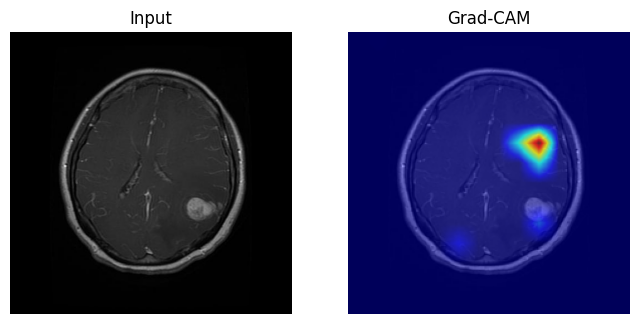

In [33]:
# Hook the *conv* layer, not the ReLU:
sample_img   = os.path.join(TEST_DIR, 'glioma',
                 os.listdir(os.path.join(TEST_DIR,'glioma'))[11])
target_layer = model_base.features[27]  # idx 27 is Conv2d, idx 28 is ReLU
explain_image(sample_img, model_base, target_layer)